In [2]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it. In this case we can also filter the data to only the HLF variables we want to keep. 

We also keep a `flavors` data_table object to hold the flavors of each jet; this is nice for later.

In [8]:
# get h5 datasets
repo_head = utils.get_repo_info()['head']
assert len(repo_head) > 0, "not running jupyter notebook from within a repo!! Prolly won't work :-)"
data_path = os.path.join(repo_head, "data/tightSVJ/10h5/*_data.h5")

# replace above code for 'data_path' if you want something else
# loader = utils.data_loader('all data')
# loader.add_sample(data_path)
# t = loader.make_table()
# t.head()
data, jet_tables = utils.get_training_data_jets(data_path)

data.cdrop(["jetM", "*MET*", "*Delta*"], inplace=True)

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_5_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_4_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_3_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/10h5/data_2_data.h5'
data_loader

,jetEta,jetPhi,jetPt,jetChargedFraction,jetPTD,jetAxis2,jetFlavor,jetEnergy
0,0.292314,-1.215342,811.505066,0.617647,0.292997,0.015287,1.0,847.437136
1,-1.108254,0.154565,792.122620,0.600000,0.234078,0.025373,3.0,1331.724071
2,0.131421,-2.197223,665.996277,0.526316,0.198135,0.021002,3.0,674.659860
3,-1.134106,1.502835,942.049133,0.619048,0.277420,0.018531,2.0,1616.606413
4,-0.058697,2.968807,753.037720,0.500000,0.407907,0.027717,2.0,756.594176
5,-0.116076,-1.582877,1224.752563,0.575758,0.193657,0.020776,4.0,1240.268663
6,-0.522428,-1.064521,1240.000854,0.672414,0.214055,0.022217,1.0,1415.601506
7,0.479513,2.142449,1163.479126,0.550000,0.283502,0.020701,3.0,1313.717833
8,0.785336,1.244235,713.023560,0.421053,0.222477,0.100818,2.0,946.259955
9,-0.561334,-1.531905,962.493652,0.378378,0.392954,0.022140,1.0,1119.513002


In [9]:
tagged, tag_index = utils.split_table_by_column(
    "jetFlavor",
    data,
    utils.delphes_jet_tags_dict,
    False
)
sizes = map(lambda x: x.shape[0], tagged)
for t,s in zip(tagged, sizes):
    print  "{} jet: {}, {}%".format(t.name, s, round(100.*s/sum(sizes), 1))

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

down:
	18.6% (9610) train
	18.2% (9389) test
	18.4% (18999) original
up:
	37.4% (19342) train
	37.7% (19499) test
	37.6% (38841) original
strange:
	24.7% (12766) train
	24.4% (12611) test
	24.5% (25377) original
charm:
	9.0% (4657) train
	9.5% (4920) test
	9.3% (9577) original
bottom:
	3.3% (1697) train
	3.2% (1644) test
	3.2% (3341) original
gluon:
	7.0% (3636) train
	7.0% (3645) test
	7.0% (7281) original
data_table :: plotting distrubution(s) for table(s) ['train_down', 'test_down', 'down']


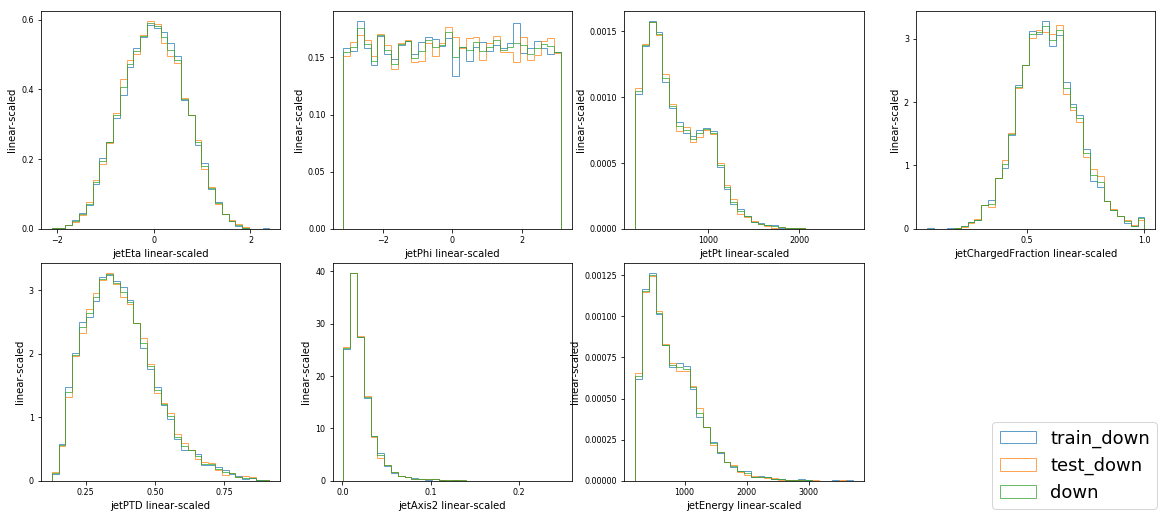

data_table :: plotting distrubution(s) for table(s) ['train_up', 'test_up', 'up']


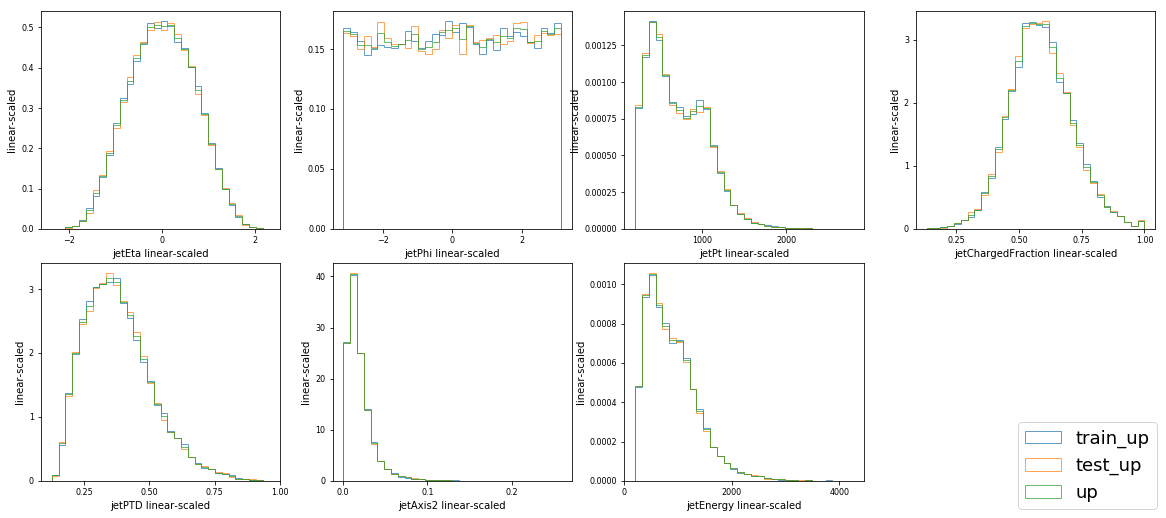

data_table :: plotting distrubution(s) for table(s) ['train_strange', 'test_strange', 'strange']


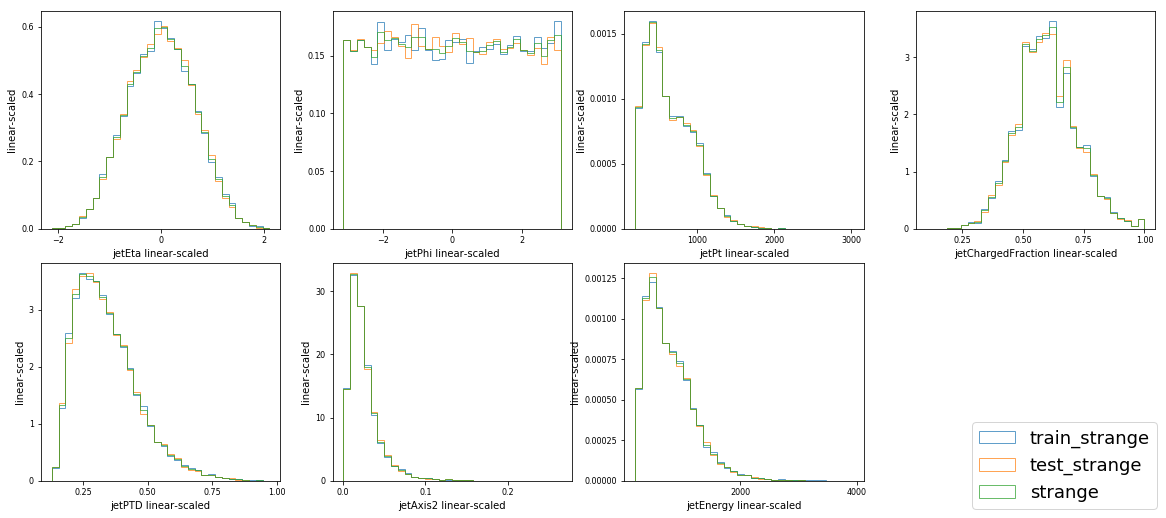

data_table :: plotting distrubution(s) for table(s) ['train_charm', 'test_charm', 'charm']


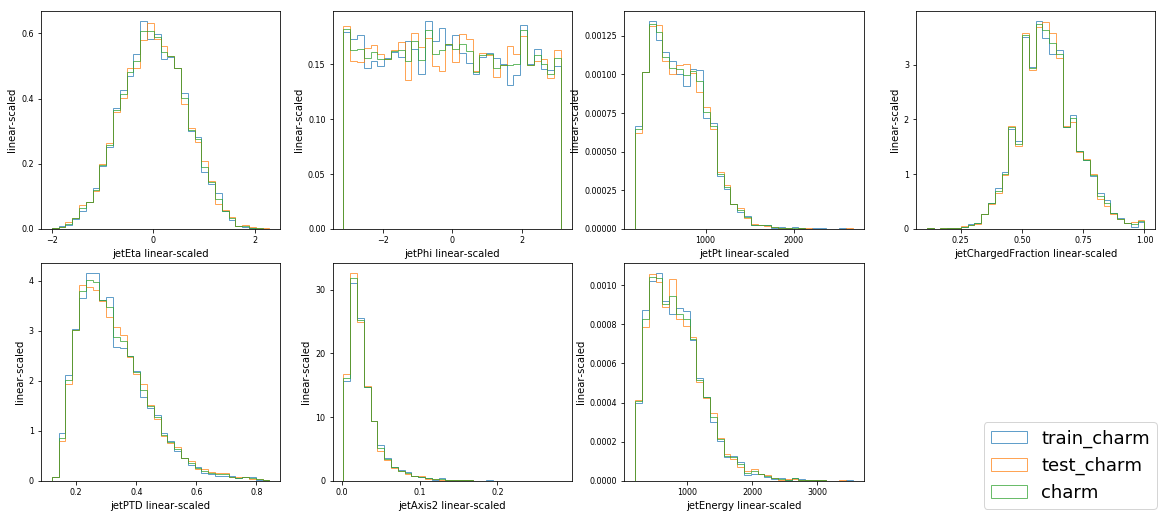

data_table :: plotting distrubution(s) for table(s) ['train_bottom', 'test_bottom', 'bottom']


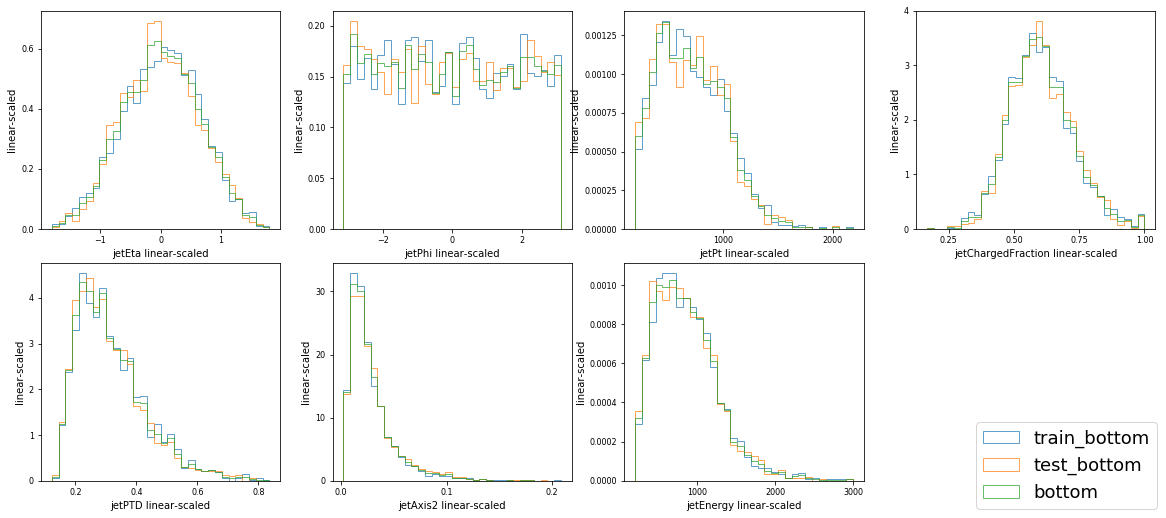

data_table :: plotting distrubution(s) for table(s) ['train_gluon', 'test_gluon', 'gluon']


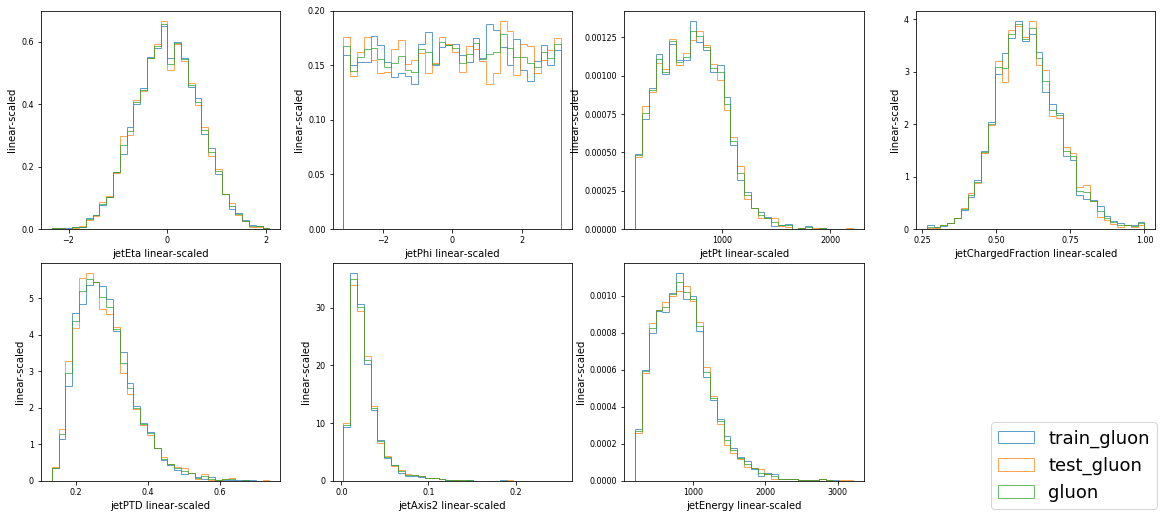

In [10]:
split = 0.5

train, test = data.train_test_split(split)

train_tags, test_tags = map(
    lambda x: utils.split_table_by_column(
        "jetFlavor", x,
        utils.delphes_jet_tags_dict, False
    )[0],
    [train, test]
)

for trt, tet in zip(train_tags, test_tags):
    print "{}:".format(trt.name)
    print "\t{:.1f}% ({}) train".format(100.*trt.shape[0]/train.shape[0], trt.shape[0])
    print "\t{:.1f}% ({}) test".format(100.*tet.shape[0]/test.shape[0], tet.shape[0])
    print "\t{:.1f}% ({}) original".format(100.*(tet.shape[0] + trt.shape[0])/data.shape[0], trt.shape[0] + tet.shape[0])

    for full, trt, tet in zip(tagged, train_tags, test_tags):
        trt.name = "train_" + trt.name
        tet.name = "test_" + tet.name
        trt.plot([tet, full], normed=1)

# data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
# data.plot(jet_tables, normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)

data_table :: plotting distrubution(s) for table(s) ['down', 'up', 'strange', 'charm', 'bottom', 'gluon']


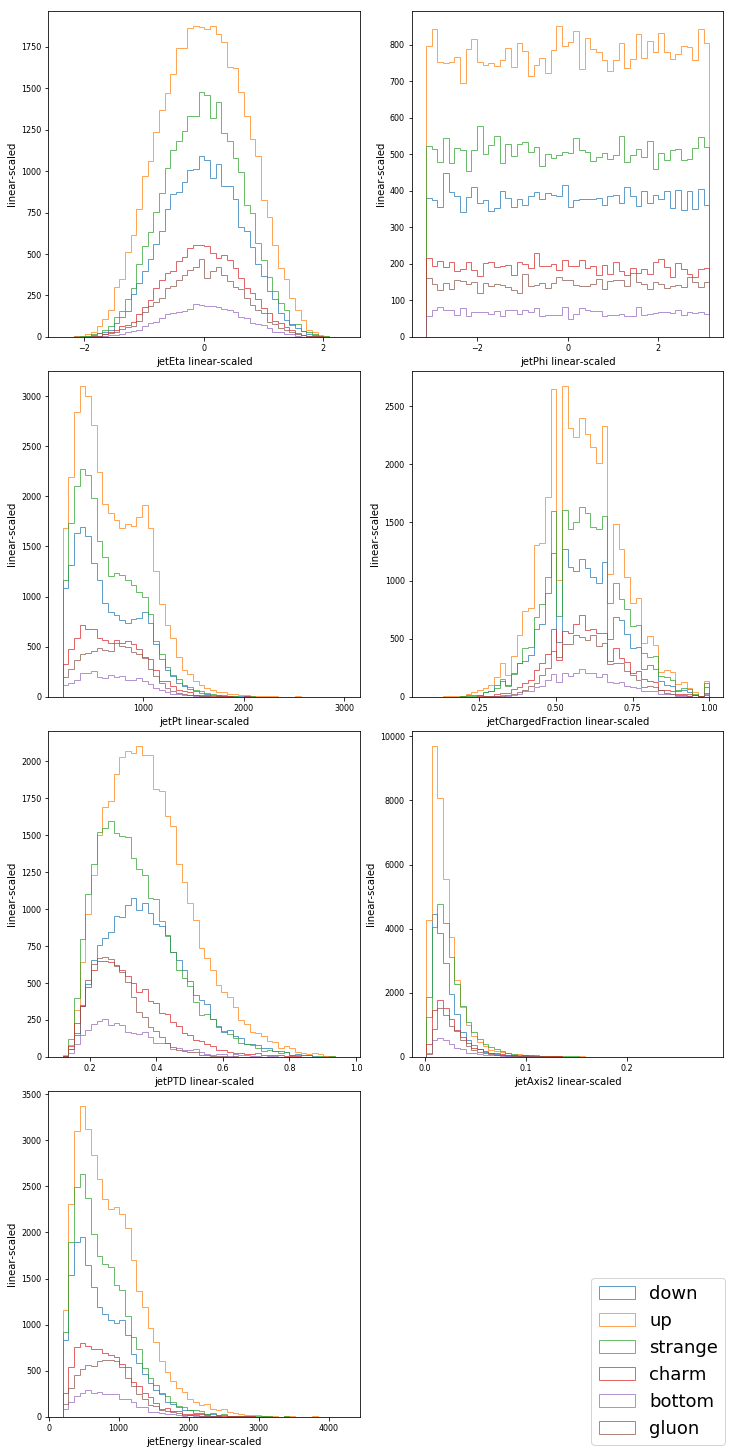

In [19]:
tagged[0].plot(tagged[1:], normed=0, bins=50, cols=2, figsize=(10,20))

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetChargedFraction', 'jetPTD', 'jetAxis2', 'jetEnergy']


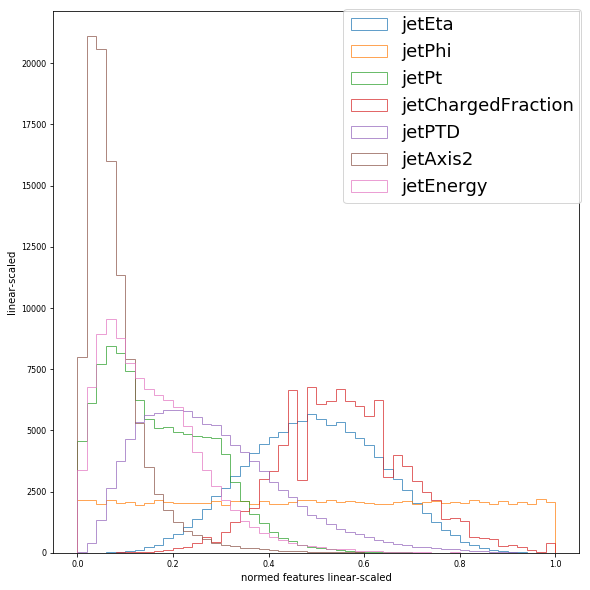

In [103]:
raw = data.cdrop("*Flavor")

norm_args = {
    "norm_type": "MinMaxScaler",
#     "feature_range": (0.01, 0.99)
}

norm = raw.norm(**norm_args)
features = [utils.data_table(norm[c].values.reshape(norm[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10, figloc="upper right")

train.cdrop("*Flavor", inplace=True)
test.cdrop("*Flavor", inplace=True)
train_norm, test_norm = train.norm(**norm_args), train.norm(test, **norm_args)


# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [126]:
def K_custom_loss(true, pred):
    x = true[:,0:7]
    mu, sigma = pred[:,0:7], pred[:,7:14]
    return K.mean(K.sum(0.5*((x - mu)/sigma)**2. - K.log(1.0/(2.*sigma*np.sqrt(2.0*np.pi))), axis=-1))

def custom_loss(true, pred):
    mu, sigma = pred[:,0:7], pred[:,7:14]
    return np.sum(0.5*((true - mu)/sigma)**2. - np.log(1.0/(2.*sigma*np.sqrt(2.0*np.pi))), axis=-1)

def diff(true, pred):
    mus, sigmas = pred[:,0:7], pred[:,7:14]
    loss = np.zeros(true.shape[0])
    for i in range(7):
        mu = mus[:,i]
        sigma = sigmas[:,i]
        x = true[:,i]
#         print 
        loss += 0.5*((x - mu)/sigma)**2. - np.log(1.0/(2.*sigma*np.sqrt(2.0*np.pi)))
    return loss

# recon = autoencoder.predict(train_norm.data)
# custom_loss(train_norm.data, train_norm.data)
cus = custom_loss(train_norm.data, recon)
dif = diff(train_norm.data, recon)
ker = np.asarray(K.eval(K_custom_loss(K.variable(train_norm.data), K.variable(recon))))
print np.all(np.isclose(cus,dif))
print np.all(np.isclose(cus,ker))

True
False


In [127]:
def min_layer(inputs, size, name, activation="linear", min_value=10e-6, offset=0):
    set_to = min_value + offset
    ret = keras.layers.Dense(size, activation="linear")(inputs)
    def lambda_func(s, m):
        def subfunc(x):
            mask = K.cast(K.greater(x, m), 'float32')
            return x*mask + (1. - mask)*s
        return subfunc
    
    return keras.layers.Lambda(
        lambda_func(set_to, min_value), output_shape=(size,), name=name
    )(ret)
    

inputs = keras.layers.Input(shape=(7,), name="input")
encoded = keras.layers.Dense(30, activation="relu", name="dense_encode")(inputs)
encoded = keras.layers.Dense(5, activation="relu", name="encoded")(encoded)
encoder = keras.Model(inputs=inputs, outputs=encoded, name="encoder")

decoder_inputs = keras.layers.Input(shape=(5,), name="decoder_inputs")
decoded = keras.layers.Dense(30, activation="relu", name="dense_decode")(decoder_inputs)
# decoded = keras.layers.Dense(20, activation="linear")(decoded)
mus = keras.layers.Dense(7, activation="linear", name="mus")(decoded)
sigmas = min_layer(decoded, 7, "sigmas")

decoded = keras.layers.concatenate([mus, sigmas], axis=-1)
decoder = keras.Model(inputs=decoder_inputs, outputs=decoded, name="decoder")

autoencoder = keras.Model(inputs=inputs, outputs=decoder(encoder(inputs)), name="autoencoder")
autoencoder.compile(optimizer="adam", loss=K_custom_loss)

In [133]:
name = "custom_5_test_prime1"
instance = trainer.trainer(os.path.join(os.path.join(repo_head, "autoencode/data/training_runs/7jf/custom"), name))

h5_elt 'metric_names' :: creating group 'data' in file 'custom_5_test_prime1.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'custom_5_test_prime1.h5'
h5_elt 'training' :: creating group 'params' in file 'custom_5_test_prime1.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'custom_5_test_prime1.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'custom_5_test_prime1.h5'


... and the model summaries:

In [134]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7)                 0         
_________________________________________________________________
dense_encode (Dense)         (None, 30)                240       
_________________________________________________________________
encoded (Dense)              (None, 5)                 155       
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


decoder summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, 5)            0                                            
___________________________________________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [135]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [138]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

train_pad = np.pad(train_norm.data, ((0,0),(0,14 - train_norm.data.shape[1])), 'constant')
test_pad = np.pad(test_norm.data, ((0,0),(0,14 - test_norm.data.shape[1])), 'constant')

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_pad,
    y_test=test_pad,
#     y_train=np.ones((train_norm.shape[0], 20)),
#     y_test=np.ones((test_norm.shape[0], 20)),
    optimizer="adam",
    loss=K_custom_loss,
    epochs=10,
    model=autoencoder,
    metrics=[],
    force=True,
    batch_size=200,
    use_callbacks=False,
    learning_rate=0.025,
)

train_shell :: using model passed as function argument
train_shell :: TRAINING EPOCH 4/14
Train on 51708 samples, validate on 51708 samples
Epoch 5/5
51/51 [==============================] - 6s 110ms/step - loss: 248399.2690 - val_loss: 0.5994
train_shell :: TRAINING EPOCH 5/14
Train on 51708 samples, validate on 51708 samples
Epoch 6/6
51/51 [==============================] - 6s 117ms/step - loss: -0.1070 - val_loss: -0.5610
train_shell :: TRAINING EPOCH 6/14
Train on 51708 samples, validate on 51708 samples
Epoch 7/7
51/51 [==============================] - 5s 105ms/step - loss: -0.5582 - val_loss: -0.5828
train_shell :: TRAINING EPOCH 7/14
Train on 51708 samples, validate on 51708 samples
Epoch 8/8
51/51 [==============================] - 4s 79ms/step - loss: -0.5631 - val_loss: -0.5872
train_shell :: TRAINING EPOCH 8/14
Train on 51708 samples, validate on 51708 samples
Epoch 9/9
51/51 [==============================] - 5s 94ms/step - loss: -0.5637 - val_loss: -0.5861
train_shell ::

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

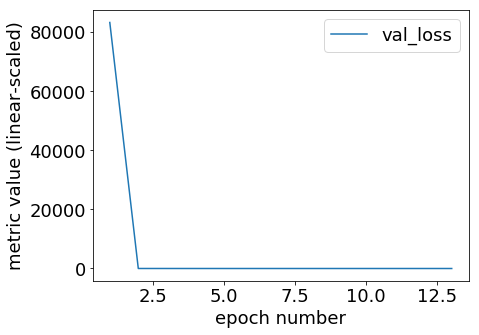

In [141]:
instance.plot_metrics(fnmatch_criteria="val_loss", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

In [123]:
def np_lognormal(x,a1,a2,a3):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return a3/(x*a2*np.sqrt(2.*np.pi))*np.exp(-(np.log(x) - a1)**2./(2.*a2*a2))
      
def np_gaussian(x, a1, a2):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return (1./(a2*np.sqrt(2.*np.pi)))*np.exp((-(x - a1)*(x - a1))/(2.*a2*a2))

def np_phi_pdf(x, frac, sig1, sig2):
#     ret = K.cast(K.greater(sig1, 0), 'float32')*K.cast(K.greater(sig2, 0), 'float32')
    ratio = np_gaussian(0, 0, sig1)/np_gaussian(0, 0, sig2)
    f1 = frac/ratio
    f2 = frac*ratio
    ret = f1*np_gaussian(x, 0.01, sig1) + f2*np_gaussian(x, .255, sig2) + f1*np_gaussian(x, .5, sig1) + f2*np_gaussian(x, .745, sig2) + f1*np_gaussian(x, .99, sig1)
    mask = np.where(ret > 0.)[0].astype(float)
    return ret*mask + (1. - mask)*10e-8


def np_phi_gaussians(x, dist, frac, sig1, sig2):
    f1 = 1./frac
    f2 = frac
    return  np.asarray([f1*np_gaussian(x, 0, sig1), f2*np_gaussian(x, 1.*dist, sig2), f1*np_gaussian(x, 2.*dist, sig1), f2*np_gaussian(x, 3.*dist, sig2), f1*np_gaussian(x, 4.*dist, sig1)])

def get_probabilities(true, pred):
    ret = []
    mus, sigmas, skews, others = pred[:,0:6], pred[:,6:14], pred[:,14:18], pred[:,18:20]
    ret.append(np_gaussian(true[:,0], mus[:,0], sigmas[:,0]))
    ret.append(np_phi_pdf(true[:,1], others[:,0], sigmas[:,1], sigmas[:,2]))
    ret.append(np_lognormal(true[:,2], mus[:,1], sigmas[:,3], skews[:,0]))
    ret.append(np_lognormal(true[:,3], mus[:,2], sigmas[:,4], skews[:,1]))
    ret.append(np_gaussian(true[:,4], mus[:,3], sigmas[:,5]))
    ret.append(np_lognormal(true[:,5], mus[:,4], sigmas[:,6], skews[:,2]))
    ret.append(np_lognormal(true[:,6], mus[:,5], sigmas[:,7], skews[:,3]))
    return np.asarray(ret)

def get_dist(x, pred):
    ret = np.empty((7, x.shape[0]))
    mus, sigmas, skews, others = pred[0:6], pred[6:14], pred[14:18], pred[18:20]
    ret[0] = np_gaussian(x, mus[0], sigmas[0])
    ret[1] = np_phi_pdf(x, others[0], sigmas[1], sigmas[2])
    ret[2] = np_lognormal(x, mus[1], sigmas[3], skews[0])
    ret[3] = np_lognormal(x, mus[2], sigmas[4], skews[1])
    ret[4] = np_gaussian(x, mus[3], sigmas[5])
    ret[5] = np_lognormal(x, mus[4], sigmas[6], skews[2])
    ret[6] = np_lognormal(x, mus[5], sigmas[7], skews[3])
    return ret

def get_all_lh(Pred, rng=(0.01, 0.99), points=1000):
    x = np.linspace(rng[0], rng[1], points)
    lret = []
    for pred in Pred:
        mus, sigmas, skews, others = pred[0:6], pred[6:14], pred[14:18], pred[18:20]
        ret = []
        ret.append(np_gaussian(x, mus[0], sigmas[0]))
        ret.append(np_phi_pdf(x, others[0], sigmas[1], sigmas[2]))
        ret.append(np_lognormal(x, mus[1], sigmas[3], skews[0]))
        ret.append(np_lognormal(x, mus[2], sigmas[4], skews[1]))
        ret.append(np_gaussian(x, mus[3], sigmas[5]))
        ret.append(np_lognormal(x, mus[4], sigmas[6], skews[2]))
        ret.append(np_lognormal(x, mus[5], sigmas[7], skews[3]))
        lret.append(ret)
    return x,np.asarray(lret)

def get_avg_lh(Pred, rng=(0.01, 0.99), points=1000):
    x = np.linspace(rng[0], rng[1], points)
    pred = Pred.mean(axis=0)
    mus, sigmas, skews, others = pred[0:6], pred[6:14], pred[14:18], pred[18:20]
    ret = []
    ret.append(np_gaussian(x, mus[0], sigmas[0]))
    ret.append(np_phi_pdf(x, others[0], sigmas[1], sigmas[2]))
    ret.append(np_lognormal(x, mus[1], sigmas[3], skews[0]))
    ret.append(np_lognormal(x, mus[2], sigmas[4], skews[1]))
    ret.append(np_gaussian(x, mus[3], sigmas[5]))
    ret.append(np_lognormal(x, mus[4], sigmas[6], skews[2]))
    ret.append(np_lognormal(x, mus[5], sigmas[7], skews[3]))
    
    return x,np.asarray(ret)
    
    
pred = autoencoder.predict(test_norm.data)

weights = get_probabilities(test_norm.data, pred).T
x,ll = get_avg_lh(pred)


from sklearn.preprocessing import MinMaxScaler

weights = MinMaxScaler().fit_transform(weights)

# for i,w in enumerate(weights.T):
# #     plt.hist(w, bins=30, normed=1, histtype='step')

#     plt.hist(test_norm.data[:,i], weights=w, bins=50, normed=1, histtype='step', label='pred')
#     plt.hist(test_norm.data[:,i], bins=50, normed=1, histtype='step', label='true')
#     plt.legend()
#     plt.show()
# # print pred.shape
# # lplot = ll.mean(axis=0)
# for i,l in enumerate(lplot):
#     bc, bins = np.histogram(norm_data.data[:,i], bins=50, normed=1)
#     plt.scatter(x, l/l.max())
#     plt.step(bins[1:], bc/bc.max())
#     plt.show()

IndexError: index 0 is out of bounds for axis 1 with size 0

In [287]:
x = np.linspace(0.01, .99, 100)
np.diff(x)

print x.shape
for p in pred:
    pdf = get_dist(x, p)
    pdf
#     print pdf.shape

(100,)


In [142]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), headers=["val {}".format(i+1) for i in range(5)], name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), headers=["val {}".format(i+1) for i in range(5)], name="test_reps")
)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


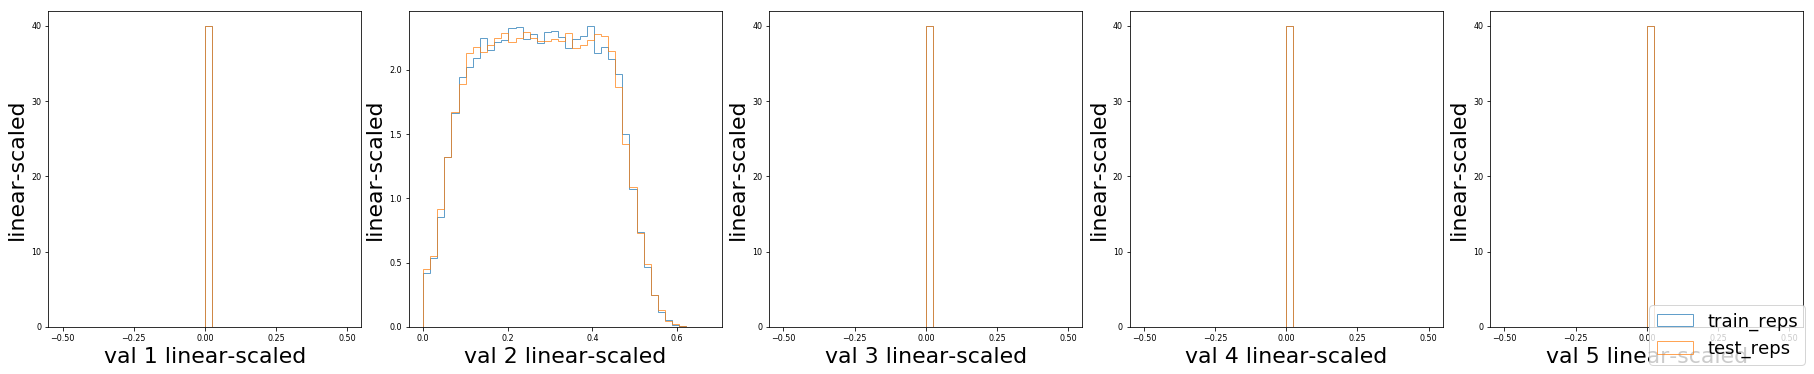

In [143]:
train_reps.plot([test_reps], cols=5, figsize=(25,5), fontsize=22, normed=1, bins=40)

In [120]:
errors = utils.data_table(np.asarray(map(
        lambda x: keras.backend.eval(getattr(keras.losses, x)(data.norm(**norm_args).data, data_recon_norm.data)),
        ["mse", "mae"]
    )).T,                      
    headers=["mse", "mae"],
    name="errors"
)

NameError: global name 'data_recon_norm' is not defined

data_table :: plotting distrubution(s) for table(s) ['errors']


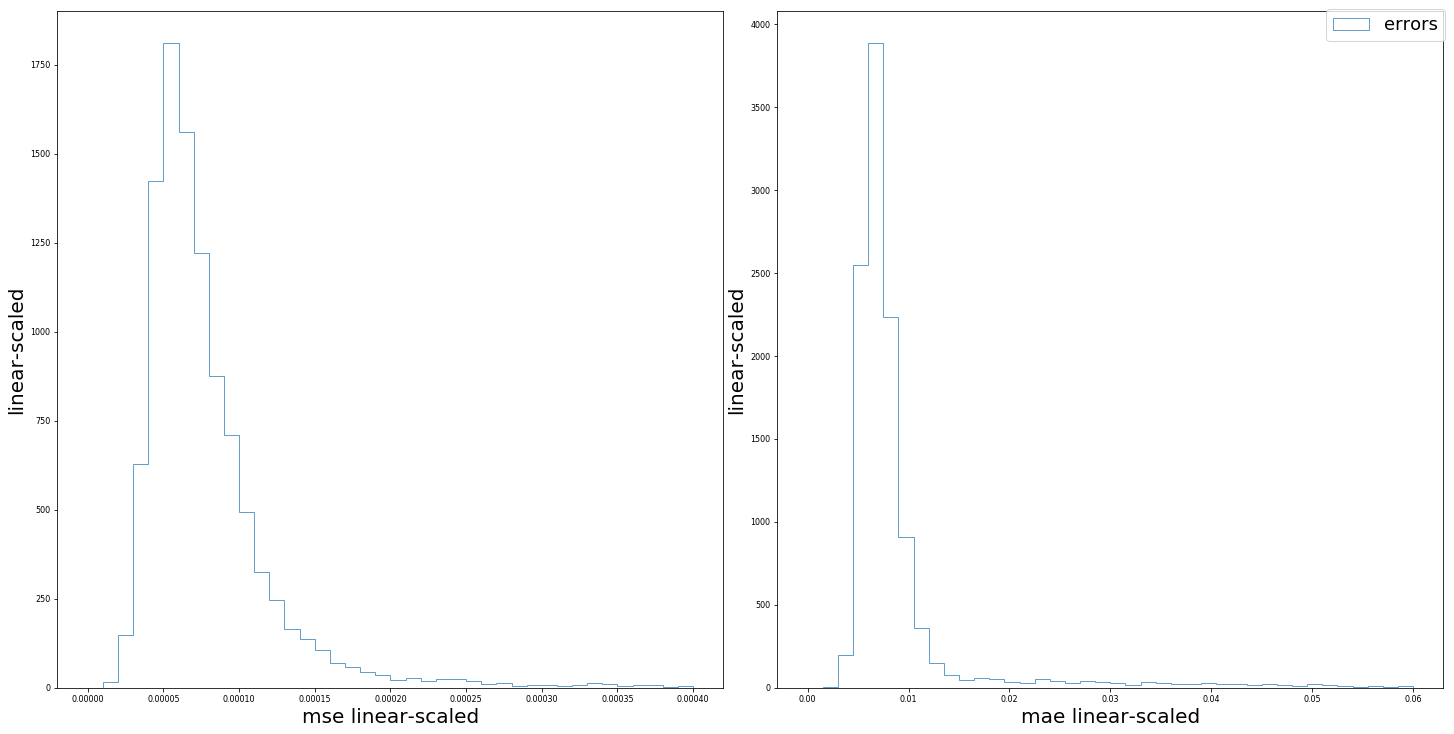

In [643]:
errors.plot(figsize=(20,10), bins=40, rng=((0,0.0004), (0, 0.06)), fontsize=20)

In [646]:
outlier_fraction = 0.01
index = np.argsort(errors.mae)
out_index = index[-int(outlier_fraction*len(errors)):]
reg_index = index[:-int(outlier_fraction*len(errors))]
print out_index.size + reg_index.size,len(errors)
print out_index.size, reg_index.size

11236 11236
112 11124


data_table :: plotting distrubution(s) for table(s) ['normal', 'outliers (top 0.01)']


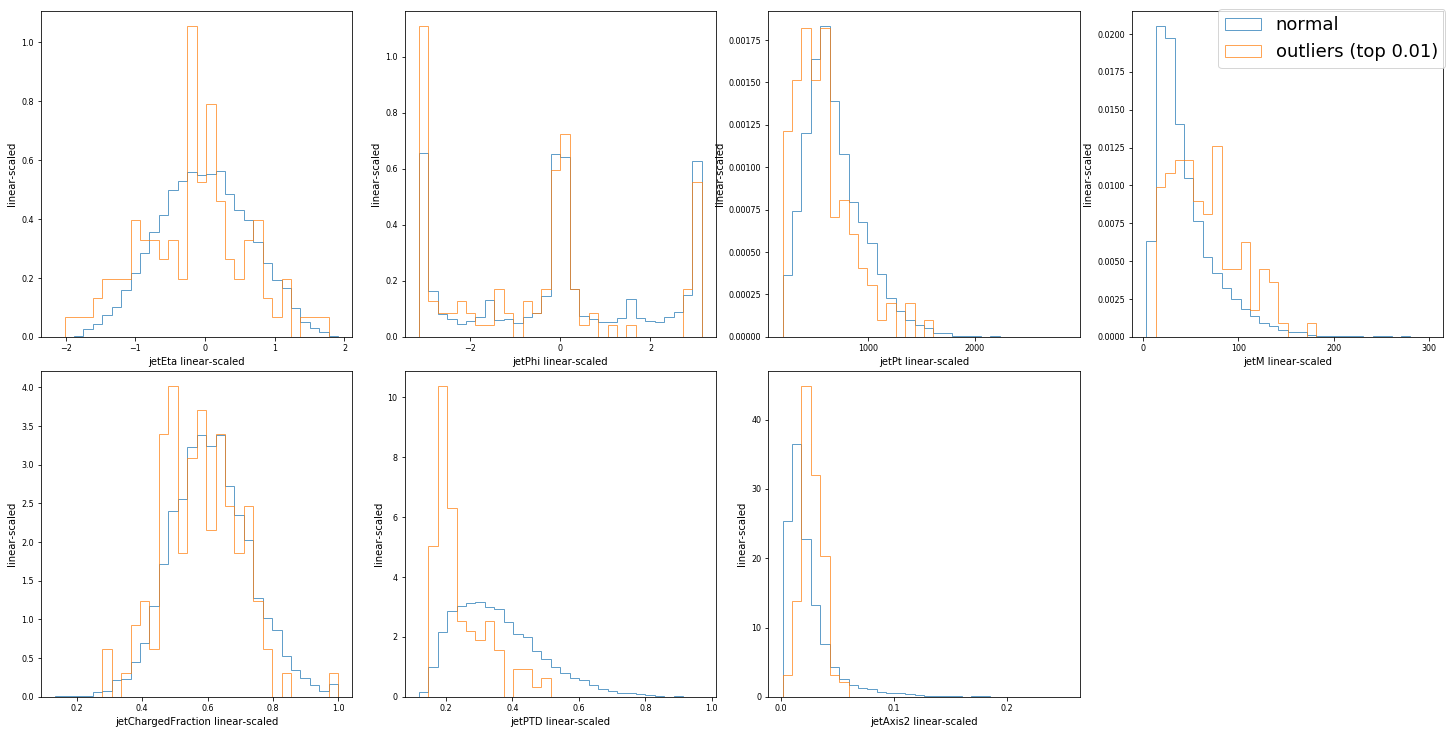

In [647]:
out,reg = (
    utils.data_table(data.data[out_index], headers=data.headers, name="outliers (top {})".format(outlier_fraction)), 
    utils.data_table(data.data[reg_index], headers=data.headers, name="normal")
)
reg.plot(out, normed=1, bins=30, figsize=(20,10))